In [6]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import rasterio
import cv2

In [3]:
data_path = '/kaggle/input/eurosat-dataset/EuroSATallBands/'
train_df = pd.read_csv(data_path + 'train.csv')
train_df.head()
print(len(train_df['Filename']))

19317


In [8]:
def load_data(filename):
    images = []
    for file in filename:
        with rasterio.open(data_path + file) as src:
            image = src.read()
            images.append(np.array(image) / 255)
    return np.array(images)

In [ ]:
train_data = load_data(train_df['Filename'])

In [10]:
def normalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

In [5]:
image_path = '/kaggle/input/eurosat-dataset/EuroSATallBands/River/River_1.tif'
with rasterio.open(image_path) as src:
    bands = src.read()
print(bands.shape)

(13, 64, 64)


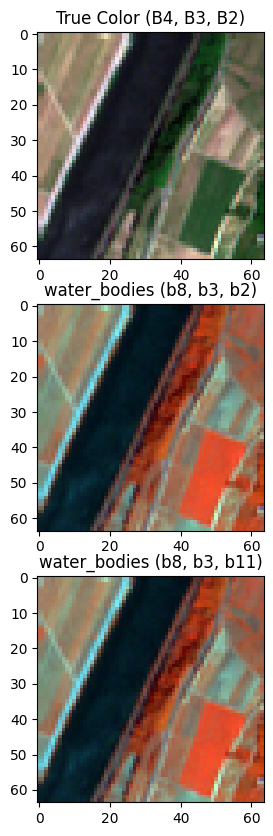

<Figure size 640x480 with 0 Axes>

In [16]:
image_path = '/kaggle/input/eurosat-dataset/EuroSATallBands/River/River_1.tif'
with rasterio.open(image_path) as img:
    band4 = img.read(4).astype(np.float32) # red 
    band3 = img.read(3).astype(np.float32) # green
    band2 = img.read(2).astype(np.float32) #blue
    band8 = img.read(8).astype(np.float32) # b8 nir
    band11 = img.read(11).astype(np.float32) # b11 swir
band4 = normalize(band4)
band3 = normalize(band3)
band2 = normalize(band2)
band8 = normalize(band8)
band11 = normalize(band11)

rgb = np.stack((band4, band3, band2), axis=-1)
water_bodies_b2 = np.stack((band8, band3, band2), axis=-1)
water_bodies_b11= np.stack((band8, band3, band2), axis=-1)
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(rgb)
ax[0].set_title("True Color (B4, B3, B2)")
ax[1].imshow(water_bodies_b2)
ax[1].set_title("water_bodies (b8, b3, b2)")
ax[2].imshow(water_bodies_b11)
ax[2].set_title("water_bodies (b8, b3, b11)")
plt.show()
plt.savefig('river_sign.png')
    

In [ ]:
print(band4)

In [8]:
# Vegetation (Forest, AnnualCrop, Pasture, PermanentCrop, HerbaceousVegetation)
categories = ['Forest', 'AnnualCrop', 'Pasture', 'PermanentCrop', 'HerbaceousVegetation']
samples = []

for c in categories:
    try:
        im_name = test_df.loc[(train_df['ClassName'] == c), 'Filename'].iloc[0]
        samples.append(str(data_path + im_name))
    except IndexError:
        print(f"No image found for category: {c}")
        samples.append(None)



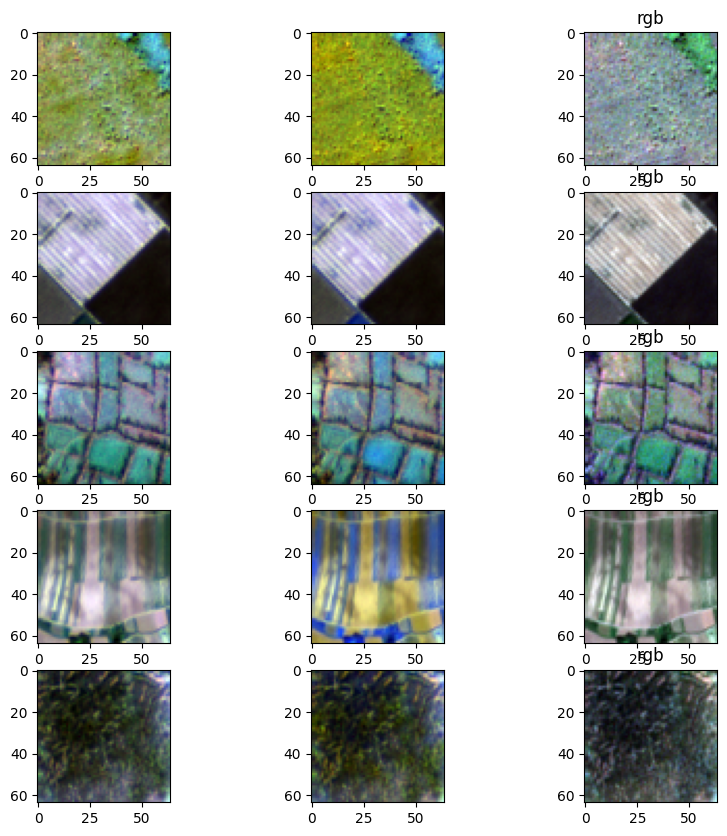

In [11]:
samples = [sample for sample in samples if sample is not None]

fig, ax = plt.subplots(len(samples), 3, figsize=(10, 10))

for i, sample in enumerate(samples):
    try:
        with rasterio.open(sample) as img:
            all_bands = img.read()
            
            # b4, b8, (b5, b7)
            band4 = normalize(all_bands[3].astype(np.float32))  # band indices are 0-based
            band8 = normalize(all_bands[7].astype(np.float32))
            band5 = normalize(all_bands[4].astype(np.float32))
            band7 = normalize(all_bands[6].astype(np.float32))
            band3 = normalize(img.read(3).astype(np.float32)) # green
            band2 = normalize(img.read(2).astype(np.float32)) #blue
        rgb = np.stack((band4, band3, band2), axis=-1)
        ax[i, 0].imshow(np.stack((band4, band3, band5), axis=-1))
        
        ax[i, 1].imshow(np.stack((band4, band3, band7), axis=-1))
        ax[i, 2].imshow(rgb)
        ax[i, 2].set_title('rgb')
    except Exception as e:
        print(f"Error processing file {sample}: {e}")

        plt.tight_layout()
        plt.savefig('samples.png')
        plt.show()

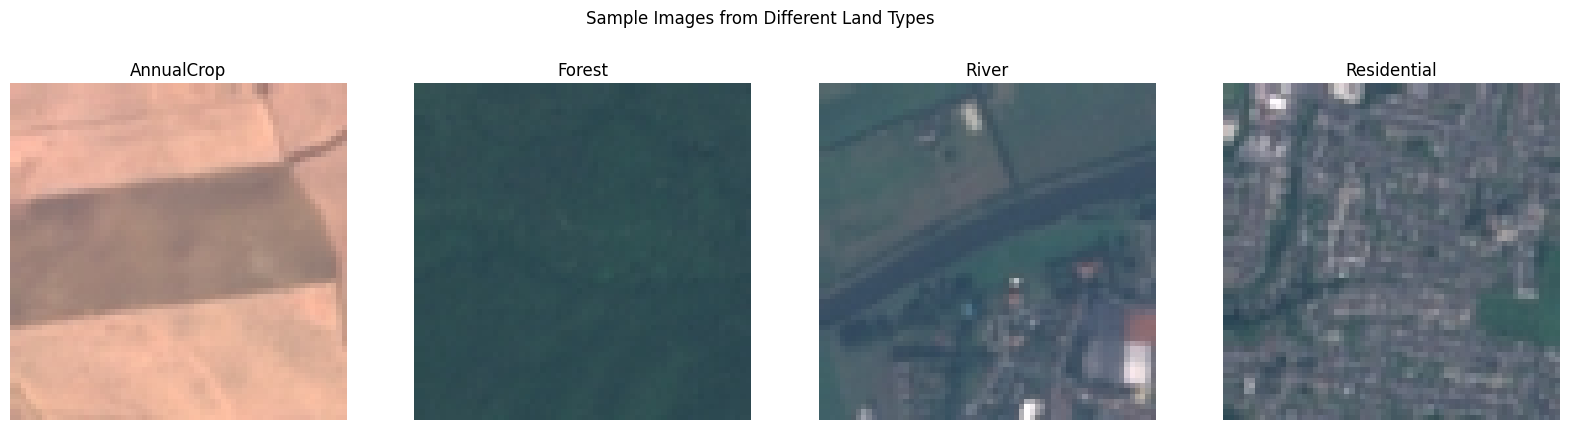

In [6]:
import matplotlib.pyplot as plt
import cv2
import os

# Define land types and sample images
land_types = ["AnnualCrop", "Forest", "River", "Residential"]
base_dir = '/kaggle/input/eurosat-dataset/EuroSAT'  # Change to your EuroSAT directory

# Plot sample images from each land type
fig, axes = plt.subplots(1, len(land_types), figsize=(20, 5))
for i, land_type in enumerate(land_types):
    # Get a sample image path
    sample_img_path = os.path.join(base_dir, land_type, os.listdir(os.path.join(base_dir, land_type))[0])
    # Read and display the image
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(land_type)
    axes[i].axis("off")

plt.suptitle("Sample Images from Different Land Types")
plt.show()


In [47]:
import numpy as np

base_dir = '/kaggle/input/eurosat-dataset/EuroSATallBands/'
land_types = ["River", "Forest", "AnnualCrop", "Residential"]
# Define spectral band names
# Update to the 9 bands actually used
# bands = ["B2 (Blue)", "B3 (Green)", "B4 (Red)", 
#          "B5 (Red Edge 1)", "B6 (Red Edge 2)", "B7 (Red Edge 3)", 
#          "B8 (NIR)", "B11 (SWIR 1)", "B12 (SWIR 2)"]
bands = [2, 3, 4, 5, 6, 7, 8, 11, 12]

In [48]:
# Function to compute average spectral signature
def get_spectral_signature(image_path):
    with rasterio.open(image_path) as src:
        num_bands = src.count
        spectral_signature = []
        # for i in range(1, num_bands + 1):
        for i in bands:
            band = src.read(i).astype(np.float32)
            band_mean = np.mean(band)
            spectral_signature.append(band_mean)
    return spectral_signature

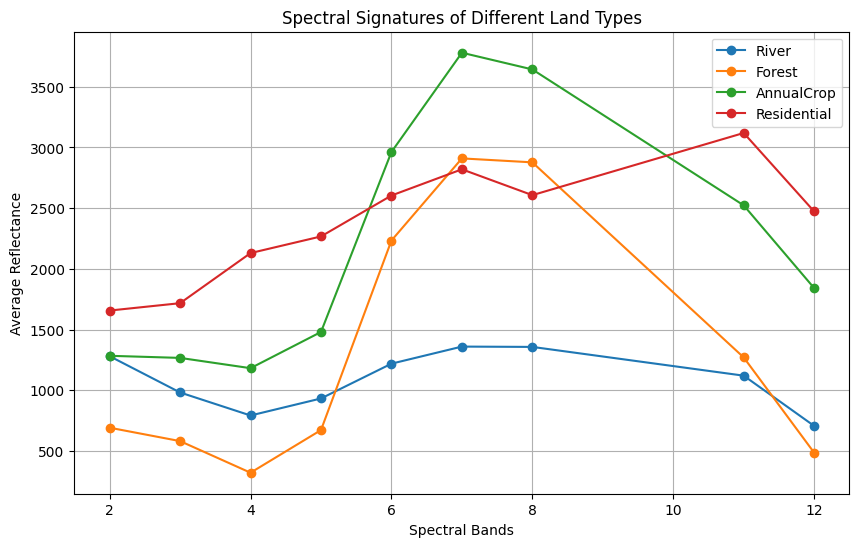

<Figure size 640x480 with 0 Axes>

In [50]:
# Collect spectral signatures for each land type
spectral_signatures = {}

for land_type in land_types:
    # Get a sample image for each land type
    sample_img_path = os.path.join(base_dir, land_type, os.listdir(os.path.join(base_dir, land_type))[0])
    spectral_signatures[land_type] = get_spectral_signature(sample_img_path)

# Plot spectral signatures for all land types
plt.figure(figsize=(10, 6))
for land_type, signature in spectral_signatures.items():
    plt.plot(bands, signature, label=land_type, marker='o')
plt.xlabel("Spectral Bands")
plt.ylabel("Average Reflectance")
plt.title("Spectral Signatures of Different Land Types")
plt.xticks()
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('SS1.png')

(3, 64, 64)


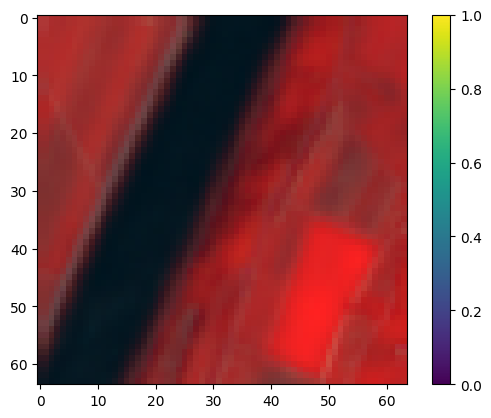

In [26]:
from rasterio.plot import show
image_path = '/kaggle/input/eurosat-dataset/EuroSATallBands/River/River_1.tif'
# Load and display a sample image
with rasterio.open(image_path) as src:
    img = src.read([13, 3, 2])
print(img.shape)
img = np.transpose(img, (1, 2, 0))
img = normalize(img)
plt.imshow(img)
plt.colorbar()
plt.show()